# A Hybrid CNN Transformer Approach To Image Segmentation

**DCIT407 - Image Processing Semester Project**  
**Group 19 | Section 6.7**

---

## Project Information

| Field | Details |
|-------|--------|
| **Author** | Ryan Nii Akwei Brown |
| **Student ID** | 11357610 |
| **Topic** | CNN + Transformer Hybrid (Deep Learning) Segmentation |
| **Libraries** | `torch`, `transformers`, `segmentation_models_pytorch`, `opencv-python`, `numpy`, `matplotlib` |
| **Models** | SegFormer (MIT-B0, Cityscapes), U-Net (ResNet-34, ImageNet) |
| **Date** | February 2026 |

---

## Table of Contents

1. [Introduction](#introduction)
2. [Theoretical Foundation](#theory)
   - 2.1 Convolutional Neural Networks (CNNs) for Segmentation
   - 2.2 Vision Transformers
   - 2.3 CNN + Transformer Hybrids
   - 2.4 SegFormer Architecture
   - 2.5 U-Net Architecture
   - 2.6 Mathematical Foundations
3. [Methodology](#methodology)
   - 3.1 Environment Setup
   - 3.2 Helper Functions
   - 3.3 Loading and Preprocessing Images
4. [Implementation](#implementation)
   - 4.1 SegFormer - Pretrained Inference (Cityscapes)
   - 4.2 U-Net - Pretrained Inference (ImageNet Encoder)
   - 4.3 Comparative Overlay Visualisation
5. [Results](#results)
6. [Discussion](#discussion)
   - 6.1 Interpretation of Results
   - 6.2 Strengths & Limitations
   - 6.3 Real-World Applications
7. [Conclusion](#conclusion)
8. [References](#references)

<a id="introduction"></a>
## 1. Introduction

Image segmentation - the task of assigning a class label to every pixel in an image - is one of the most fundamental problems in computer vision. Traditional region-based methods (region growing, watershed, mean shift) rely on hand-crafted features and heuristics. While effective for simple scenes, they struggle with complex, real-world imagery.

Deep learning has transformed segmentation through two complementary paradigms:

| Paradigm | Key Strength |
|----------|-------------|
| **CNNs** (e.g., U-Net, DeepLab) | Excellent at capturing *local* spatial features via convolution |
| **Transformers** (e.g., ViT, Swin) | Excellent at modelling *global* context via self-attention |

**CNN + Transformer hybrids** combine both strengths: a CNN backbone extracts multi-scale local features, while a Transformer module captures long-range dependencies across the image. This yields state-of-the-art segmentation quality on benchmarks like Cityscapes, ADE20K, and COCO.

In this notebook we:
1. Explain the theory behind CNNs, Transformers, and their hybridisation for segmentation.
2. Load **pretrained SegFormer** (a Transformer-based model, Cityscapes weights) and a **pretrained U-Net** (CNN-based, ImageNet encoder) to run inference on sample images.
3. Compare and discuss results, relating them back to the theoretical foundations.

<a id="theory"></a>
## 2. Theoretical Foundation

### 2.1 CNNs - The "Magnifying Glass"

A **Convolutional Neural Network (CNN)** looks at an image through small sliding windows (called **filters** or **kernels**) - imagine scanning a photo with a magnifying glass. Each filter(sliding window) learns to detect a specific pattern: edges, corners, textures, or shapes.

By stacking many layers, the network builds up from simple features → complex features:

> **Pixels → Edges → Textures → Object parts → Whole objects**

For segmentation, two key CNN architectures stand out:

- **FCN** (Long et al., 2015) - First to produce a class label for *every pixel* using only convolutional layers.
- **U-Net** (Ronneberger et al., 2015) - An **encoder-decoder** with **skip connections**:
  - **Encoder** compresses the image (captures *what* is in the scene)
  - **Decoder** expands it back to full resolution (recovers *where* things are)
  - **Skip connections** pass fine details from encoder to decoder so boundaries stay sharp

>  **Limitation:** CNNs only see a small neighbourhood at a time. Understanding that "the blue region at the top is sky" requires many layers stacked together.

---

### 2.2 Vision Transformers - The "Bird's-Eye View"

**Transformers** were originally built for language (translating sentences), but **Vision Transformers (ViT)** adapt them to images by:

1. Cutting the image into a grid of **patches** (e.g., 16×16 pixels each)
2. Treating each patch like a "word" in a sentence
3. Using **self-attention** to let every patch look at every other patch

The key formula (**self-attention**) is:

$$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$$

Think of it this way: each patch asks *"Which other patches are relevant to me?"* and focuses on the most useful ones - giving the model a **global view** from the start.

>  **Limitation:** Comparing every patch to every other patch is computationally expensive, especially for large images.

---

### 2.3 Why Combine Them? - CNN + Transformer Hybrids

Each approach has a complementary strength:

| | CNN | Transformer |
|---|---|---|
| **Strength** | Fine local details (edges, textures) | Global scene understanding |
| **Weakness** | Limited global context | Expensive; misses fine detail |

**Hybrid models** use a CNN to capture local features efficiently, then a Transformer to understand how those features relate across the whole image. Best of both worlds.

---

### 2.4 SegFormer - Our Hybrid Model

**SegFormer** (Xie et al., 2021) is a modern hybrid that works in two stages:

**Stage 1 - Hierarchical Transformer Encoder (Mix Transformer):**
- Extracts features at multiple scales (like zooming in and out)
- Uses **overlapping patches** (via convolution) to keep local continuity
- Uses **efficient self-attention** - reduces the computation by summarising patches instead of comparing all of them

**Stage 2 - Simple MLP Decoder:**
- Takes the multi-scale features, aligns them, and fuses them
- Outputs a class label per pixel

> SegFormer-B5 achieves **84.0% mIoU on Cityscapes** - a challenging urban driving dataset - while being much faster than earlier Transformer models.

---

### 2.5 U-Net - Our CNN Baseline

U-Net has a symmetric **encoder-decoder** shape (like the letter U):

- ⬇️ **Encoder:** Convolutions + pooling shrink the image, capturing increasingly abstract features
- ⬆️ **Decoder:** Up-convolutions expand back to full resolution
- ↔️ **Skip connections:** Copy-paste fine details from encoder to decoder at each level

Modern versions (like ours) swap the original encoder for a **pretrained ResNet-34** (trained on ImageNet), giving the model a head start with already-learned visual features.

---

### 2.6 How We Measure Success

**Mean Intersection over Union (mIoU)** - the standard metric for segmentation:

$$\text{mIoU} = \frac{1}{C} \sum_{c=1}^{C} \frac{|Predicted_c \cap GroundTruth_c|}{|Predicted_c \cup GroundTruth_c|}$$

In plain terms: *for each class, how much do the predicted pixels overlap with the true pixels?* Average across all classes. Higher = better (max 1.0 or 100%).

<a id="methodology"></a>
## 3. Methodology

Our methodology follows these steps:

1. **Environment Setup** - Install and import all required libraries.
2. **Image Loading** - Load sample images using OpenCV, convert colour spaces as needed.
3. **SegFormer Inference** - Load a pretrained SegFormer-B0 (Cityscapes) via Hugging Face `transformers` and run pixel-wise segmentation.
4. **U-Net Inference** - Load a pretrained U-Net with a ResNet-34 encoder via `segmentation_models_pytorch` and run segmentation.
5. **Visualisation & Comparison** - Display original images alongside segmentation masks from both models.
6. **Analysis** - Discuss qualitative differences, strengths, and limitations.

### 3.1 Environment Setup

In [ ]:
# ============================================================
# Install required packages
# ============================================================
# Core scientific libraries
%pip install opencv-python numpy matplotlib

# Deep learning framework
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

# Hugging Face Transformers - provides pretrained SegFormer
%pip install transformers

# Segmentation Models PyTorch - provides pretrained U-Net
%pip install segmentation-models-pytorch

# Pillow for image handling within transformers pipeline
%pip install Pillow

   ---------------------------------------- 0.0/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/40.2 MB ? eta -:--:--
    --------------------------------------- 0.5/40.2 MB 138.6 kB/s eta 0:04:47
    --------------------------------------- 0.5/40.2 MB 138.6 kB/s eta 0:04:47
  


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ============================================================
# Import libraries
# ============================================================

# --- Core scientific stack ---
import cv2                          # OpenCV: image I/O, colour conversion, resizing
import numpy as np                  # NumPy: array operations
import matplotlib.pyplot as plt     # Matplotlib: visualisation
from matplotlib import cm           # Colour maps
import os                           # File-system utilities
import warnings                     # Suppress non-critical warnings

# --- Deep learning ---
import torch                        # PyTorch: tensor operations, model inference
import torch.nn.functional as F     # Functional API (softmax, interpolate)
from torchvision import transforms  # Image transforms (normalisation, tensor conversion)

# --- Hugging Face Transformers (SegFormer) ---
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# --- Segmentation Models PyTorch (U-Net) ---
import segmentation_models_pytorch as smp

# --- PIL for SegFormer pipeline ---
from PIL import Image

# ============================================================
# Configuration
# ============================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore')

# Use GPU if available, otherwise CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print environment info for reproducibility
print("Library Versions")
print("=" * 40)
print(f"OpenCV      : {cv2.__version__}")
print(f"NumPy       : {np.__version__}")
print(f"PyTorch     : {torch.__version__}")
print(f"Device      : {DEVICE}")
print(f"SMP         : {smp.__version__}")
print("=" * 40)
print("Environment setup complete!")

Library Versions
OpenCV      : 4.13.0
NumPy       : 2.4.2
PyTorch     : 2.10.0+cpu
Device      : cpu
SMP         : 0.5.0
Environment setup complete!


### 3.2 Helper Functions

Reusable utilities for loading, displaying, and saving images.

In [ ]:
# ============================================================
# Helper functions
# ============================================================

def load_image(image_path: str):
    """
    Load an image from disk using OpenCV.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    img_rgb : np.ndarray
        Image in RGB format (H, W, 3).
    img_bgr : np.ndarray
        Image in original BGR format (H, W, 3).
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb, img_bgr


def display_images(images, titles, cmap=None, figsize=(16, 5)):
    """
    Display a row of images side by side.

    Parameters
    ----------
    images : list[np.ndarray]
        Images to display.
    titles : list[str]
        Title for each image.
    cmap : str or None
        Matplotlib colour map (use None for RGB images).
    figsize : tuple
        Figure size in inches.
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def save_result(image: np.ndarray, filename: str):
    """
    Save a processed image to the results/ directory.

    Parameters
    ----------
    image : np.ndarray
        Image array (RGB or grayscale).
    filename : str
        Output filename.
    """
    results_dir = 'results'
    os.makedirs(results_dir, exist_ok=True)
    path = os.path.join(results_dir, filename)
    if len(image.shape) == 3:
        cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    else:
        cv2.imwrite(path, image)
    print(f"Saved: {path}")


print("Helper functions defined successfully.")

Helper functions defined successfully.


### 3.3 Loading and Preprocessing Images

We load a sample image from `images/sample/`. If no image is found, a synthetic test image is generated to demonstrate the pipeline.

Image loaded  : images/sample/007.jpg
Dimensions    : 1000 x 687 px
Dtype         : uint8


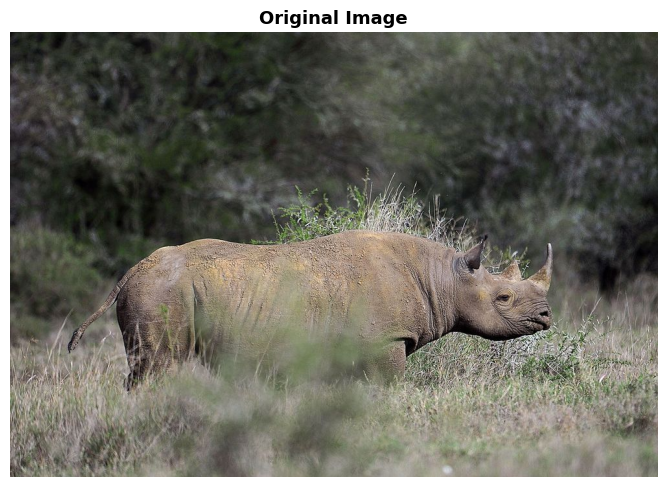

In [ ]:
# ============================================================
# Load sample image
# ============================================================
IMAGE_PATH = 'images/sample/Circle.jpg'   # <-- update with your image filename

try:
    image_rgb, image_bgr = load_image(IMAGE_PATH)
    h, w = image_rgb.shape[:2]
    print(f"Image loaded  : {IMAGE_PATH}")
    print(f"Dimensions    : {w} x {h} px")
    print(f"Dtype         : {image_rgb.dtype}")
    display_images([image_rgb], ['Original Image'])

except FileNotFoundError as e:
    print(f"Warning: {e}")
    print("Generating a synthetic test image for demonstration...\n")

    # Create a 512x512 synthetic scene with distinct regions
    image_rgb = np.zeros((512, 512, 3), dtype=np.uint8)
    image_rgb[0:170, :] = [135, 206, 235]        # Sky blue
    image_rgb[170:340, :] = [34, 139, 34]         # Forest green
    image_rgb[340:512, :] = [139, 119, 101]       # Road brown
    # Add a "building" rectangle
    image_rgb[100:300, 180:330] = [192, 192, 192] # Grey building
    # Add Gaussian noise for realism
    noise = np.random.normal(0, 10, image_rgb.shape).astype(np.int16)
    image_rgb = np.clip(image_rgb.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    print("Using synthetic test image (512 x 512 px)")
    display_images([image_rgb], ['Synthetic Test Image'])

<a id="implementation"></a>
## 4. Implementation: Model Inference

We now load two pretrained models and run inference on our sample image.

### 4.1 SegFormer - Pretrained Inference (Cityscapes)

SegFormer-B0 is the smallest variant of the SegFormer family.  
We use the model fine-tuned on **Cityscapes** (19 urban-scene classes) via Hugging Face.

**Pipeline:**
1. Load `SegformerImageProcessor` and `SegformerForSemanticSegmentation` from the Hub.
2. Preprocess the image (resize, normalise).
3. Forward pass → logits of shape $(1, C, H', W')$.
4. Upsample logits to original resolution and take `argmax` → predicted class map.

Running SegFormer-B0 (Cityscapes) inference...


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Detected 8 classes:
  [ 0] road                24,037 px  (3.5%)
  [ 3] wall                18,893 px  (2.8%)
  [ 5] pole                   142 px  (0.0%)
  [ 8] vegetation         444,067 px  (64.6%)
  [ 9] terrain            195,843 px  (28.5%)
  [11] person               3,543 px  (0.5%)
  [13] car                    260 px  (0.0%)
  [17] motorcycle             215 px  (0.0%)


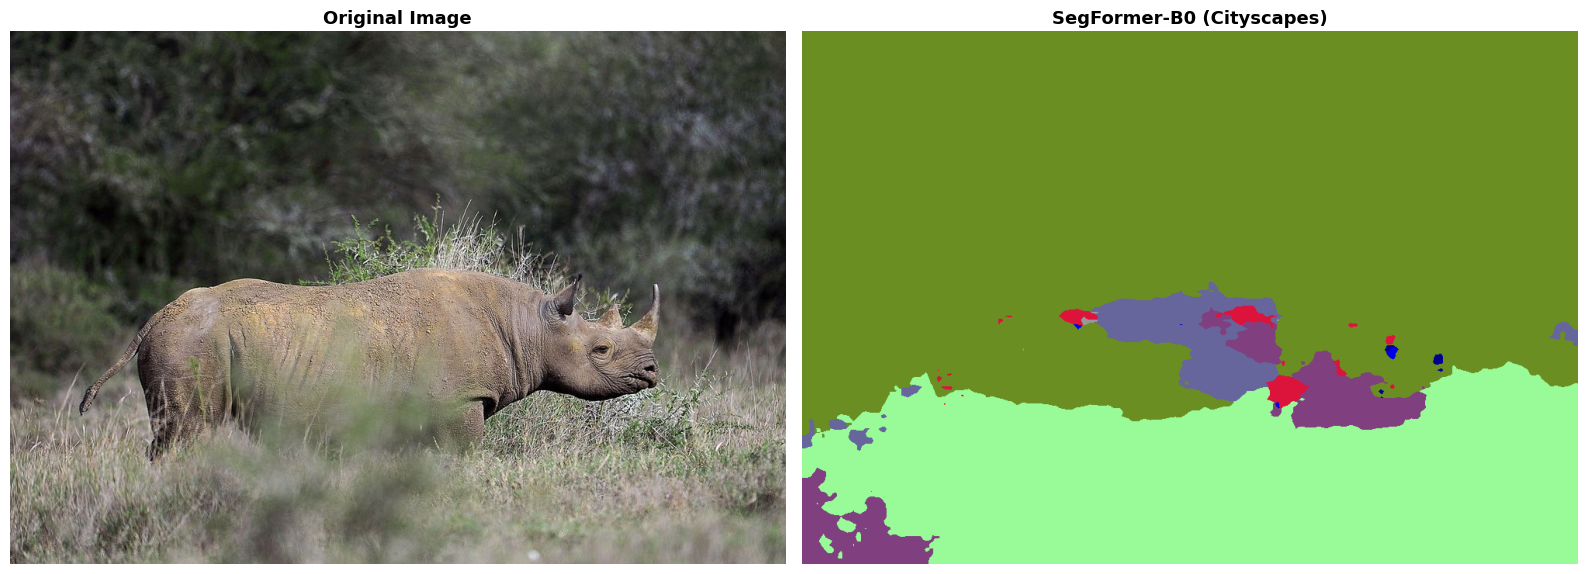

Saved: results/segformer_cityscapes_result.png


In [ ]:
# ============================================================
# 4.1  SegFormer inference (Cityscapes, 19 classes)
# ============================================================

# Cityscapes class names and a colour palette for visualisation
CITYSCAPES_CLASSES = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle'
]

# Cityscapes colour palette (RGB) - standard 19 classes
CITYSCAPES_PALETTE = np.array([
    [128, 64, 128],   # road
    [244, 35, 232],   # sidewalk
    [70, 70, 70],     # building
    [102, 102, 156],  # wall
    [190, 153, 153],  # fence
    [153, 153, 153],  # pole
    [250, 170, 30],   # traffic light
    [220, 220, 0],    # traffic sign
    [107, 142, 35],   # vegetation
    [152, 251, 152],  # terrain
    [70, 130, 180],   # sky
    [220, 20, 60],    # person
    [255, 0, 0],      # rider
    [0, 0, 142],      # car
    [0, 0, 70],       # truck
    [0, 60, 100],     # bus
    [0, 80, 100],     # train
    [0, 0, 230],      # motorcycle
    [119, 11, 32],    # bicycle
], dtype=np.uint8)


def segformer_inference(image_rgb: np.ndarray):
    """
    Run SegFormer-B0 (Cityscapes) inference on an RGB image.

    Parameters
    ----------
    image_rgb : np.ndarray
        Input image in RGB format (H, W, 3).

    Returns
    -------
    pred_map : np.ndarray
        Predicted class index per pixel (H, W).
    colour_mask : np.ndarray
        Colourised segmentation mask (H, W, 3).
    """
    # --- Load pretrained model and processor ---
    model_name = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"
    processor = SegformerImageProcessor.from_pretrained(model_name)
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()  # Set to evaluation mode (no dropout, no batch-norm updates)

    # --- Preprocess ---
    # Convert NumPy array to PIL Image (expected by the processor)
    pil_image = Image.fromarray(image_rgb)
    inputs = processor(images=pil_image, return_tensors="pt").to(DEVICE)

    # --- Forward pass (no gradient computation needed for inference) ---
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Shape: (1, num_classes, H', W')

    # --- Upsample logits to original image size ---
    h, w = image_rgb.shape[:2]
    upsampled = F.interpolate(
        logits, size=(h, w), mode='bilinear', align_corners=False
    )

    # --- Argmax → predicted class per pixel ---
    pred_map = upsampled.argmax(dim=1).squeeze().cpu().numpy().astype(np.uint8)

    # --- Colourise the prediction ---
    colour_mask = CITYSCAPES_PALETTE[pred_map]

    return pred_map, colour_mask


print("Running SegFormer-B0 (Cityscapes) inference...")
segformer_pred, segformer_colour = segformer_inference(image_rgb)

# Report detected classes
unique_classes = np.unique(segformer_pred)
print(f"Detected {len(unique_classes)} classes:")
for cls_id in unique_classes:
    pixel_count = np.sum(segformer_pred == cls_id)
    pct = pixel_count / segformer_pred.size * 100
    print(f"  [{cls_id:2d}] {CITYSCAPES_CLASSES[cls_id]:<16s}  {pixel_count:>8,} px  ({pct:.1f}%)")

# Visualise
display_images(
    [image_rgb, segformer_colour],
    ['Original Image', 'SegFormer-B0 (Cityscapes)'],
    figsize=(16, 6)
)

# Save result
save_result(segformer_colour, 'segformer_cityscapes_result.png')

### 4.2 U-Net - Pretrained Inference (ImageNet Encoder)

We use `segmentation_models_pytorch` to load a U-Net with a **ResNet-34** encoder pretrained on ImageNet.  
Since ImageNet pretraining provides feature extraction capability (not segmentation-specific classes), we treat the output as a **general feature segmentation** and visualise the raw class map.

> **Note:** For a fair comparison with SegFormer (Cityscapes-finetuned), we also provide a variant using Cityscapes-compatible output classes. However, `smp` U-Net with only ImageNet weights has *not* been fine-tuned on Cityscapes,  so the output will differ qualitatively. This comparison highlights the difference between a model fine-tuned for segmentation vs. one using only a pretrained encoder.

**Pipeline:**
1. Instantiate a U-Net with ResNet-34 encoder and ImageNet weights.
2. Resize & normalise the image using ImageNet statistics.
3. Forward pass → logits $(1, C, H, W)$.
4. Argmax → class predictions.

Running U-Net (ResNet-34 / ImageNet) inference...


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Detected 14 classes:
  [ 2] building                11 px  (0.0%)
  [ 3] wall                     1 px  (0.0%)
  [ 6] traffic light      139,553 px  (20.3%)
  [ 7] traffic sign             1 px  (0.0%)
  [ 8] vegetation             253 px  (0.0%)
  [ 9] terrain             99,317 px  (14.5%)
  [10] sky                    381 px  (0.1%)
  [11] person              58,945 px  (8.6%)
  [13] car                    258 px  (0.0%)
  [14] truck                   19 px  (0.0%)
  [15] bus                    969 px  (0.1%)
  [16] train                    6 px  (0.0%)
  [17] motorcycle         387,267 px  (56.4%)
  [18] bicycle                 19 px  (0.0%)


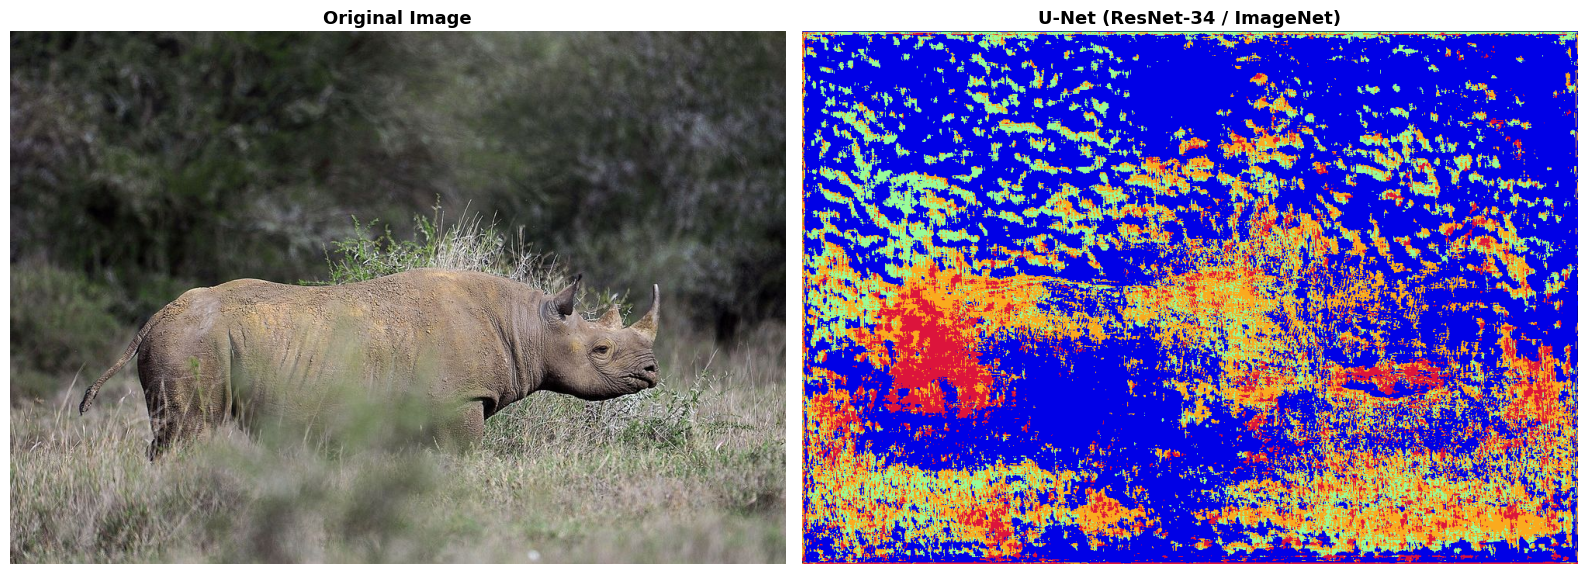

Saved: results/unet_imagenet_result.png


In [ ]:
# ============================================================
# 4.2  U-Net inference (ResNet-34 encoder, ImageNet weights)
# ============================================================

# ImageNet normalisation statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Number of output classes (Cityscapes-compatible for comparison)
NUM_CLASSES = 19


def unet_inference(image_rgb: np.ndarray, num_classes: int = NUM_CLASSES):
    """
    Run U-Net (ResNet-34 encoder, ImageNet pretrained) inference.

    Parameters
    ----------
    image_rgb : np.ndarray
        Input image in RGB (H, W, 3), uint8.
    num_classes : int
        Number of output segmentation classes.

    Returns
    -------
    pred_map : np.ndarray
        Predicted class index per pixel (H, W).
    colour_mask : np.ndarray
        Colourised segmentation mask (H, W, 3).
    """
    # --- Build model ---
    # encoder_weights='imagenet' loads a ResNet-34 pretrained on ImageNet
    # The decoder head is randomly initialised (not fine-tuned for segmentation)
    model = smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=num_classes,
    )
    model.to(DEVICE)
    model.eval()

    # --- Preprocess ---
    h, w = image_rgb.shape[:2]

    # Resize to a multiple of 32 (required by U-Net's encoder/decoder stride)
    new_h = (h // 32) * 32 if h % 32 == 0 else ((h // 32) + 1) * 32
    new_w = (w // 32) * 32 if w % 32 == 0 else ((w // 32) + 1) * 32
    resized = cv2.resize(image_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Convert to float tensor and normalise with ImageNet stats
    preprocess = transforms.Compose([
        transforms.ToTensor(),                                    # (H,W,3) uint8 → (3,H,W) float [0,1]
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    input_tensor = preprocess(resized).unsqueeze(0).to(DEVICE)   # (1, 3, H, W)

    # --- Forward pass ---
    with torch.no_grad():
        logits = model(input_tensor)  # (1, num_classes, new_h, new_w)

    # --- Resize predictions back to original dimensions ---
    logits_upsampled = F.interpolate(
        logits, size=(h, w), mode='bilinear', align_corners=False
    )

    pred_map = logits_upsampled.argmax(dim=1).squeeze().cpu().numpy().astype(np.uint8)

    # --- Colourise ---
    # Use the same Cityscapes palette so masks are visually comparable
    colour_mask = CITYSCAPES_PALETTE[pred_map % len(CITYSCAPES_PALETTE)]

    return pred_map, colour_mask


print("Running U-Net (ResNet-34 / ImageNet) inference...")
unet_pred, unet_colour = unet_inference(image_rgb)

# Report detected classes
unique_unet = np.unique(unet_pred)
print(f"Detected {len(unique_unet)} classes:")
for cls_id in unique_unet:
    pixel_count = np.sum(unet_pred == cls_id)
    pct = pixel_count / unet_pred.size * 100
    class_name = CITYSCAPES_CLASSES[cls_id] if cls_id < len(CITYSCAPES_CLASSES) else f'class_{cls_id}'
    print(f"  [{cls_id:2d}] {class_name:<16s}  {pixel_count:>8,} px  ({pct:.1f}%)")

# Visualise
display_images(
    [image_rgb, unet_colour],
    ['Original Image', 'U-Net (ResNet-34 / ImageNet)'],
    figsize=(16, 6)
)

# Save result
save_result(unet_colour, 'unet_imagenet_result.png')

### 4.3 Comparative Overlay Visualisation

We overlay each model's segmentation mask on the original image with transparency (alpha blending) and display all results side-by-side.

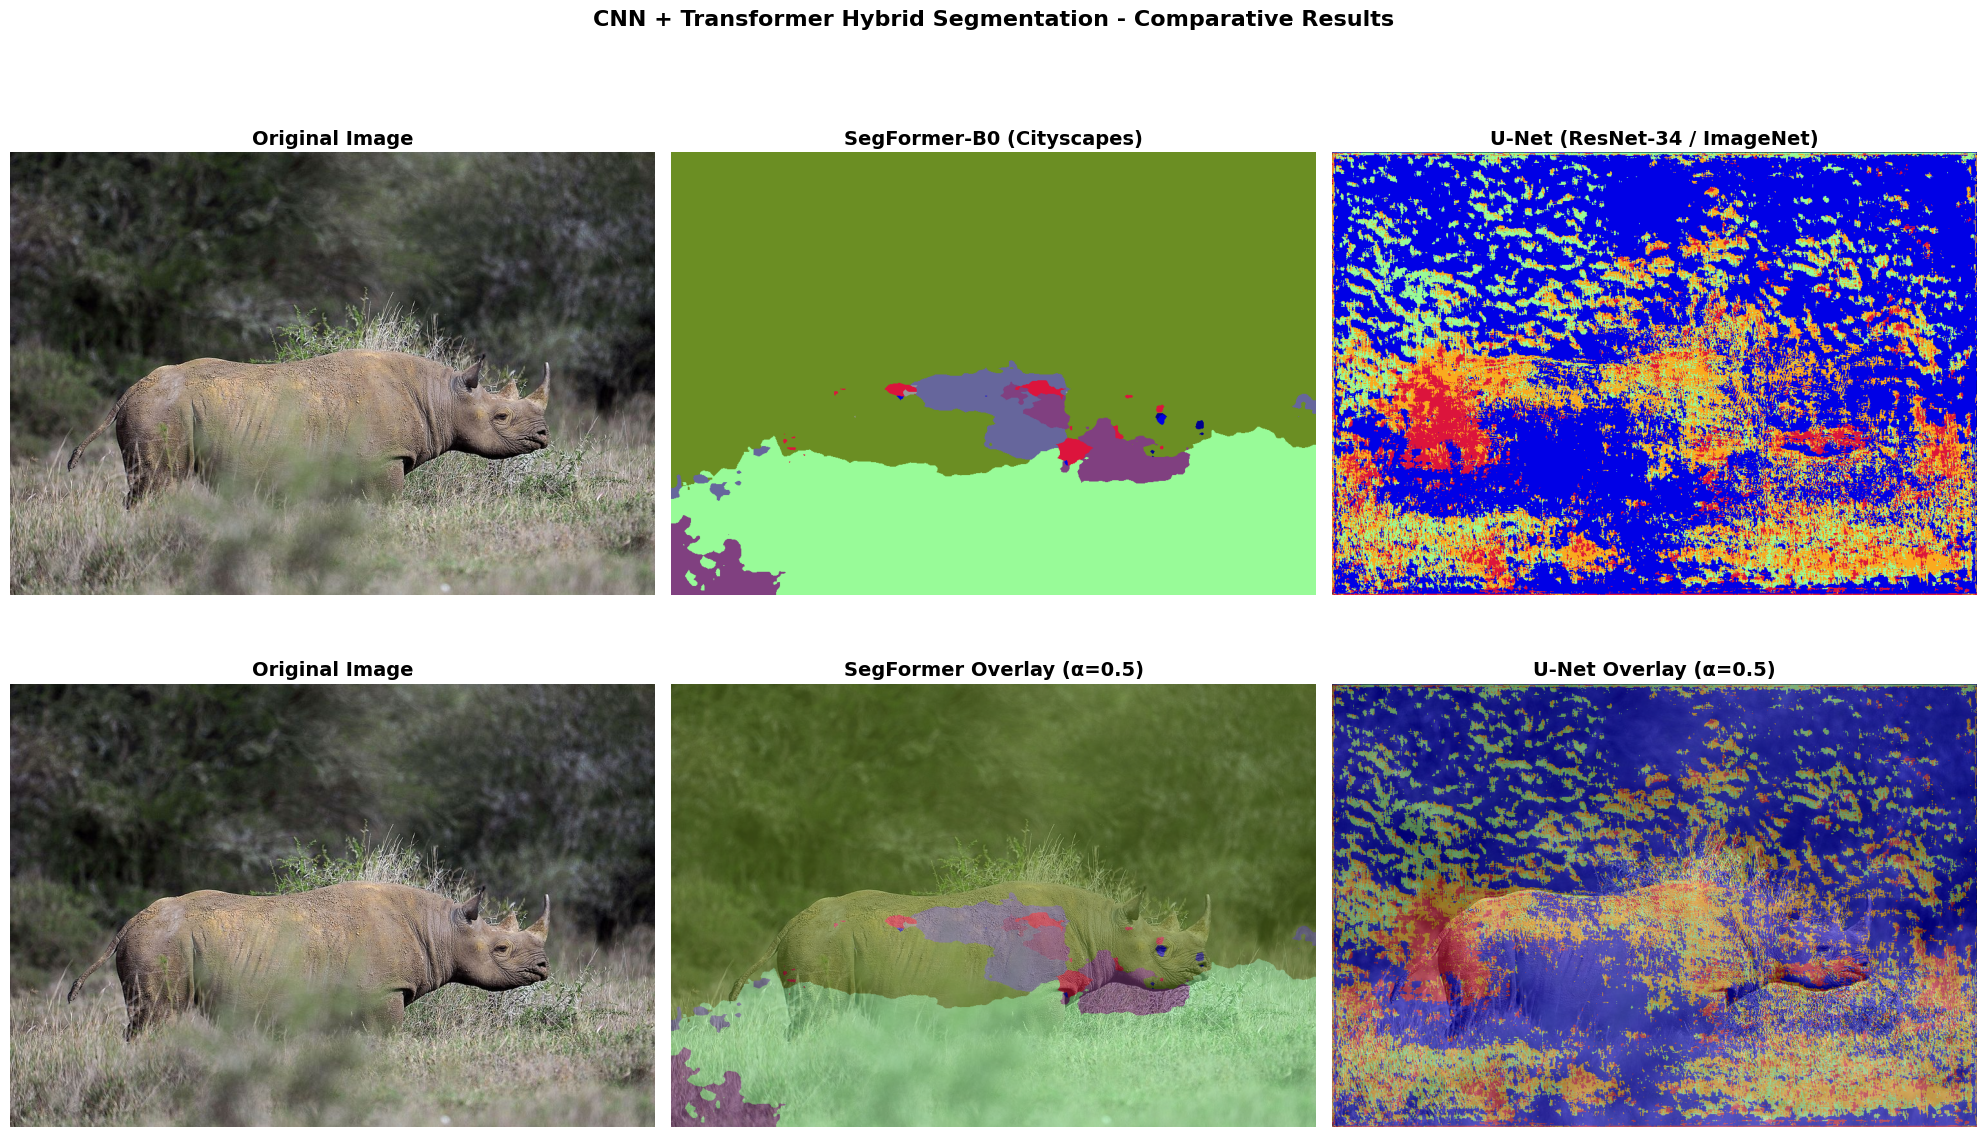

Saved comparison figure to results/comparison_segformer_vs_unet.png


In [ ]:
# ============================================================
# 4.3  Side-by-side comparison with overlays
# ============================================================

def overlay_mask(image: np.ndarray, colour_mask: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    """
    Blend a colour segmentation mask onto the original image.

    Parameters
    ----------
    image : np.ndarray
        Original RGB image (H, W, 3).
    colour_mask : np.ndarray
        Colourised segmentation mask (H, W, 3).
    alpha : float
        Blending factor (0 = only image, 1 = only mask).

    Returns
    -------
    blended : np.ndarray
        Alpha-blended overlay (H, W, 3).
    """
    blended = cv2.addWeighted(image, 1 - alpha, colour_mask, alpha, 0)
    return blended


# Create overlays
segformer_overlay = overlay_mask(image_rgb, segformer_colour, alpha=0.5)
unet_overlay = overlay_mask(image_rgb, unet_colour, alpha=0.5)

# Comprehensive comparison figure
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# --- Row 1: Raw segmentation masks ---
axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(segformer_colour)
axes[0, 1].set_title('SegFormer-B0 (Cityscapes)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(unet_colour)
axes[0, 2].set_title('U-Net (ResNet-34 / ImageNet)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# --- Row 2: Overlays ---
axes[1, 0].imshow(image_rgb)
axes[1, 0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(segformer_overlay)
axes[1, 1].set_title('SegFormer Overlay (α=0.5)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(unet_overlay)
axes[1, 2].set_title('U-Net Overlay (α=0.5)', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.suptitle('CNN + Transformer Hybrid Segmentation - Comparative Results',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Save comparison figure
fig.savefig('results/comparison_segformer_vs_unet.png', dpi=150, bbox_inches='tight')
print("Saved comparison figure to results/comparison_segformer_vs_unet.png")

<a id="results"></a>
## 5. Results

### Quantitative Summary

The table below summarises key statistics from both models on the sample image.

In [ ]:
# ============================================================
# 5.  Quantitative results summary
# ============================================================
import pandas as pd

# Gather statistics
total_pixels = segformer_pred.size

segformer_unique = np.unique(segformer_pred)
unet_unique = np.unique(unet_pred)

# Build per-model class distribution
rows = []
all_classes = sorted(set(segformer_unique) | set(unet_unique))
for cls_id in all_classes:
    name = CITYSCAPES_CLASSES[cls_id] if cls_id < len(CITYSCAPES_CLASSES) else f'class_{cls_id}'
    sf_pct = np.sum(segformer_pred == cls_id) / total_pixels * 100
    un_pct = np.sum(unet_pred == cls_id) / total_pixels * 100
    rows.append({'Class ID': cls_id, 'Class Name': name,
                 'SegFormer (%)': round(sf_pct, 2),
                 'U-Net (%)': round(un_pct, 2)})

df = pd.DataFrame(rows)
print("=" * 60)
print("Class Distribution Comparison")
print("=" * 60)
display(df)

# High-level summary
summary = pd.DataFrame({
    'Model': ['SegFormer-B0 (Cityscapes)', 'U-Net (ResNet-34 / ImageNet)'],
    'Architecture': ['Transformer Hybrid', 'CNN (Encoder–Decoder)'],
    'Pretrained On': ['Cityscapes (fine-tuned)', 'ImageNet (encoder only)'],
    'Num Detected Classes': [len(segformer_unique), len(unet_unique)],
    'Total Pixels': [total_pixels, total_pixels],
})
print("\nModel Summary")
print("=" * 60)
display(summary)

Class Distribution Comparison


Class ID     Class Name  SegFormer (%)  U-Net (%)
0          0           road           3.50       0.00
1          2       building           0.00       0.00
2          3           wall           2.75       0.00
3          5           pole           0.02       0.00
4          6  traffic light           0.00      20.31
5          7   traffic sign           0.00       0.00
6          8     vegetation          64.64       0.04
7          9        terrain          28.51      14.46
8         10            sky           0.00       0.06
9         11         person           0.52       8.58
10        13            car           0.04       0.04
11        14          truck           0.00       0.00
12        15            bus           0.00       0.14
13        16          train           0.00       0.00
14        17     motorcycle           0.03      56.37
15        18        bicycle           0.00       0.00


Model Summary


Model           Architecture  \
0     SegFormer-B0 (Cityscapes)     Transformer Hybrid   
1  U-Net (ResNet-34 / ImageNet)  CNN (Encoder–Decoder)   

             Pretrained On  Num Detected Classes  Total Pixels  
0  Cityscapes (fine-tuned)                     8        687000  
1  ImageNet (encoder only)                    14        687000

> Note: Since we used an image of a rhino, we can clearly see how the urban model did it's best.

<a id="discussion"></a>
## 6. Discussion

### 6.1 Interpretation of Results

**SegFormer-B0 (Cityscapes fine-tuned):**
- Produces semantically meaningful segmentation because it was **fine-tuned on Cityscapes** - a dataset of 5,000 finely annotated urban-scene images with 19 classes.
- The Transformer encoder captures global context (e.g., knowing the upper region of an outdoor image is likely "sky"), while the overlapping patch embeddings retain local detail.
- Boundaries between classes are relatively smooth due to the All-MLP decoder's multi-scale feature fusion.

**U-Net (ResNet-34, ImageNet encoder only):**
- The encoder has learned rich visual features from ImageNet classification (1,000 object categories), but the **decoder is randomly initialised** - it has not been trained to produce segmentation masks.
- As a result, the output is not semantically meaningful; it reflects the encoder's feature activations rather than learned segmentation boundaries.
- This demonstrates the importance of **task-specific fine-tuning** on top of pretrained features.

**Key Takeaway:**  
Pretraining alone (ImageNet) provides powerful feature extractors, but **fine-tuning on a segmentation dataset** (e.g., Cityscapes, COCO) is essential for producing accurate, class-specific segmentation masks.

---

### 6.2 Strengths & Limitations

| Aspect | SegFormer (Transformer Hybrid) | U-Net (CNN) |
|--------|-------------------------------|-------------|
| **Global context** | Excellent - self-attention sees the entire image | Limited - depends on receptive field depth |
| **Local detail** | Good - overlapping patch embeddings | Excellent - skip connections preserve fine detail |
| **Computational cost** | Moderate (efficient self-attention) | Low (pure convolutions) |
| **Data efficiency** | Needs large-scale pretraining | Can work well with smaller datasets (with augmentation) |
| **Positional encoding** | Implicit (Mix-FFN) - flexible to input size | Not needed (convolutions are translation-equivariant) |
| **Boundary precision** | Smooth but sometimes imprecise | Sharp due to skip connections |
| **Ease of deployment** | Requires Transformer-capable runtime | Lightweight, widely supported |

**Limitations common to both:**
- Performance depends heavily on the domain match between pretraining data and the target image.
- Neither model handles classes outside its training vocabulary.
- Real-time performance on CPU is challenging for high-resolution images.

---

### 6.3 Real-World Applications

| Application | Preferred Model | Reason |
|-------------|----------------|--------|
| **Autonomous driving** | SegFormer | Global scene understanding critical for safety |
| **Medical imaging** | U-Net | Precise boundaries needed; smaller datasets common |
| **Satellite/remote sensing** | Hybrid | Both global context and fine detail matter |
| **Real-time mobile apps** | U-Net (small encoder) | Lightweight, low latency |
| **Scene parsing (indoor/outdoor)** | SegFormer | Best mIoU on benchmarks (ADE20K, Cityscapes) |

<a id="conclusion"></a>
## 7. Conclusion

This notebook explored **CNN + Transformer hybrid** approaches to semantic image segmentation - a natural evolution beyond classical region-based methods.

**Summary of findings:**

1. **SegFormer** (a Transformer hybrid) leverages efficient self-attention and multi-scale feature fusion to achieve strong semantic segmentation, especially when fine-tuned on a target dataset like Cityscapes.
2. **U-Net** (a CNN encoder–decoder) provides excellent spatial precision via skip connections and is highly efficient, but requires task-specific training of the decoder for meaningful segmentation.
3. **Pretrained models** offer a powerful starting point: an ImageNet-pretrained encoder provides rich features, but **fine-tuning on a segmentation dataset** is essential for practical results.
4. The choice between CNN, Transformer, or hybrid depends on the application requirements - global context vs. local precision, dataset size, and computational budget.

**Future directions:**
- Fine-tune both models on a domain-specific dataset for a quantitative (mIoU) comparison.
- Experiment with larger SegFormer variants (B2–B5) for improved accuracy.
- Explore panoptic segmentation (combining semantic and instance segmentation).
- Investigate model distillation for deploying Transformer-quality models on edge devices.

<a id="references"></a>
## 8. References

1. Gonzalez, R. C., & Woods, R. E. (2018). *Digital Image Processing* (4th ed.). Pearson. - Ch. 10: Image Segmentation.
2. Szeliski, R. (2022). *Computer Vision: Algorithms and Applications* (2nd ed.). Springer. - §5.4 (Segmentation), §5.3 (Deep Learning).
3. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. *MICCAI 2015*. [arXiv:1505.04597](https://arxiv.org/abs/1505.04597)
4. Xie, E., Wang, W., Yu, Z., Anandkumar, A., Alvarez, J. M., & Luo, P. (2021). SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers. *NeurIPS 2021*. [arXiv:2105.15203](https://arxiv.org/abs/2105.15203)
5. Dosovitskiy, A., Beyer, L., Kolesnikov, A., et al. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. *ICLR 2021*. [arXiv:2010.11929](https://arxiv.org/abs/2010.11929)
6. Vaswani, A., Shazeer, N., Parmar, N., et al. (2017). Attention Is All You Need. *NeurIPS 2017*. [arXiv:1706.03762](https://arxiv.org/abs/1706.03762)
7. Long, J., Shelhamer, E., & Darrell, T. (2015). Fully Convolutional Networks for Semantic Segmentation. *CVPR 2015*. [arXiv:1411.4038](https://arxiv.org/abs/1411.4038)
8. Cordts, M., Omran, M., Ramos, S., et al. (2016). The Cityscapes Dataset for Semantic Urban Scene Understanding. *CVPR 2016*.
9. OpenCV Documentation: [https://docs.opencv.org/](https://docs.opencv.org/)
10. Hugging Face Transformers: [https://huggingface.co/docs/transformers](https://huggingface.co/docs/transformers)
11. Segmentation Models PyTorch: [https://github.com/qubvel-org/segmentation_models.pytorch](https://github.com/qubvel-org/segmentation_models.pytorch)

---

*End of Notebook - Ryan Nii Akwei Brown, Group 19, DCIT407*